## Tutorial 4 - Autoencoders

## Autoencoder
An autoencoder is not used for *supervised learning*. We will
no longer try to *predict* something about our input.
Instead, an autoencoder is considered a **generative model**:
it learns a distributed *representation* of our training data,
and can even be used to generate new instances of the training data.

An autoencoder model contains two components:

- An **encoder** that takes an image as input, and 
  outputs a low-dimensional embedding (representation)
  of the image.
- A **decoder** that takes the low-dimensional embedding,
  and reconstructs the image.

An autoencoder is typically shown like below: 

![alt text](https://i2.wp.com/www.statworx.com/wp-content/uploads/mushroom_encoder.png)

Autoencoders contain an encode stage which is similar to what we have seen with our ANNs and CNNs, followed by a decode stage which is just the reverse of the encode stage. In presenting the architecture of autoencoders we will try to use code that we have seen when working with MNIST data.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)[:4096]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



#### Architecture
The architecture is very similar to what we have seen in the past, except now the output will be the same size as the input. Notice also that we apply a sigmoid on the output data, this is to scale the output from 0 to 1.

In [2]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        encoding_dim = 32
        # encoder
        self.fc1 = nn.Linear(28 * 28, encoding_dim)
        # decoder
        self.fc2 = nn.Linear(encoding_dim, 28*28)

    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        x = F.relu(self.fc1(flattened))
        # sigmoid for scaling output from 0 to 1
        x = F.sigmoid(self.fc2(x))
        return x

#### Training an Autoencoder

How do we train an autoencoder? How do we know what
kind of "encoder" and "decoder" we want?

One observation is that if we pass an image through the encoder,
then pass the result through the decoder, we should get
roughly the same image back. Ideally, reducing the 
dimensionality and then generating the image should
give us the same result.

This observation provides us a training strategy: we will
minimize the reconstruction error of the autoencoder
across our training data.
We use a loss function called 'MSELoss', which
computes the square error at every pixel.

Beyond using a different loss function, the training 
scheme is roughly the same. Note that in the code below,
we are using a the optimizer called 'Adam'.

We switched to this optimizer not because it is specifically
used for autoencoders, but because this is the optimizer that
people tend to use in practice. Feel free to use Adam for your
other neural networks.

In [3]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    train_loader = torch.utils.data.DataLoader(mnist_data, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            recon = model(img)
            img = img.view(-1, 28 * 28)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

In [4]:
model = Autoencoder()
max_epochs = 20
outputs = train(model, num_epochs=max_epochs)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch:1, Loss:0.0685
Epoch:2, Loss:0.0608
Epoch:3, Loss:0.0496
Epoch:4, Loss:0.0459
Epoch:5, Loss:0.0420
Epoch:6, Loss:0.0372
Epoch:7, Loss:0.0383
Epoch:8, Loss:0.0348
Epoch:9, Loss:0.0325
Epoch:10, Loss:0.0301
Epoch:11, Loss:0.0247
Epoch:12, Loss:0.0259
Epoch:13, Loss:0.0288
Epoch:14, Loss:0.0232
Epoch:15, Loss:0.0211
Epoch:16, Loss:0.0206
Epoch:17, Loss:0.0196
Epoch:18, Loss:0.0185
Epoch:19, Loss:0.0188
Epoch:20, Loss:0.0174


Just like with our ANN we can have additional layers to make a deep autoencoder, also known as a stacked autoencoder.

## Convolutional Autoencoder
When working with image data it is often better to use a convolutional neural network and take advantage of the spatial relationships. The architecture for the encoder stage of a convolutional autoencoder will consist of standard convolutional layers that we have seen in our previous architectures. The decoder step will be a bit more tricky since we need a way to increase the resolution.  

We need something akin to convolution, but that goes in the *opposite* direction. We will use something called a **transpose convolution**. Transpose convolutions were first called *deconvolutions*, since it is the ``inverse'' of a convolution operation. However, the terminology was confusing since it has nothing to do with the mathematical notion of deconvolution.



### Convolution Transpose

First, let's illustrate how convolution transposes can be "inverses" of convolution layers.
We begin by creating a convolutional layer in PyTorch. This is the convolution that we will
try to find an "inverse" for.

In [5]:
conv = nn.Conv2d(in_channels=8,
                 out_channels=8,
                 kernel_size=5)

To illustrate how convolutional layers work, we'll create a random tensor
and see how the convolution acts on that tensor:

In [6]:
x = torch.randn(2, 8, 64, 64)
y = conv(x)
y.shape

torch.Size([2, 8, 60, 60])

A convolution transpose layer with the exact same specifications as above
would have the "reverse" effect on the shape.

In [8]:
convt = nn.ConvTranspose2d(in_channels=8,
                           out_channels=8,
                           kernel_size=5)
convt(y).shape # should be same as x.shape

torch.Size([2, 8, 64, 64])

And it does! Notice that the weights of this convolution transpose layer are all 
random, and are unrelated to the weights of the original `Conv2d`. So, the layer
`convt`  is not the mathematical inverse of the layer `conv`. However, with training,
the convolution transpose has the potential to learn to act as an approximate
inverse to `conv`. 

Here is another example of `convt` in action:

In [9]:
x = torch.randn(32, 8, 64, 64)
y = convt(x)
y.shape

torch.Size([32, 8, 68, 68])

Notice that the width and height of `y` is `68x68`, because the `kernel_size` is 5
and we have not added any padding. You can verify that if we start with a tensor
with resolution `68x68` and applied a `5x5` convolution, we would end up with
a tensor with resolution `64x64`.

In [10]:
conv = nn.Conv2d(in_channels=8,
                 out_channels=16,
                 kernel_size=5)
y = torch.randn(32, 8, 68, 68)
x = conv(y)
x.shape

torch.Size([32, 16, 64, 64])

As before, we can add a padding to our convolution transpose, just like we added
padding to our convolution operations:

In [11]:
convt = nn.ConvTranspose2d(in_channels=16,
                           out_channels=8,
                           kernel_size=5,
                           padding=2)
x = torch.randn(32, 16, 64, 64)
y = convt(x)
y.shape

torch.Size([32, 8, 64, 64])

More interestingly, we can add a stride to the convolution to increase our resolution!

In [15]:
convt = nn.ConvTranspose2d(in_channels=16,
                           out_channels=8,
                           kernel_size=5,
                           stride=2,
                           output_padding=1, # needed because stride=2
                           padding=0)
x = torch.randn(32, 16, 64, 64)
y = convt(x)
y.shape

torch.Size([32, 8, 132, 132])

Our resolution has doubled.

But what is actually happening? Essentially, we are adding a padding of zeros
in between every row and every column of `x`.



### Implementation of a Convolutional Autoencoder

To demonstrate the use of convolution transpose operations,
we will build a **convolutional autoencoder**. Below is an example of a *convolutional* autoencoder that uses solely convolutional layers:

In [16]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
#encoder
nn.Conv2d(1, 16, 3, stride=2, padding=1),
nn.Conv2d(16, 32, 3, stride=2, padding=1),
nn.Conv2d(32, 64, 7)

#decoder
nn.ConvTranspose2d(64, 32, 7),
nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),

(ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),)

#### Training a Convolutional Autoencoder

The training of the convolutional autoencoder will be the same as with the fully-connected autoencoder architecture we introduced in the beginning.

In [19]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5)
    train_loader = torch.utils.data.DataLoader(mnist_data, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

Now, we can train this network.

In [20]:
model = Autoencoder()
max_epochs = 20
outputs = train(model, num_epochs=max_epochs)

Epoch:1, Loss:0.0686
Epoch:2, Loss:0.0675
Epoch:3, Loss:0.0578
Epoch:4, Loss:0.0424
Epoch:5, Loss:0.0318
Epoch:6, Loss:0.0235
Epoch:7, Loss:0.0191
Epoch:8, Loss:0.0173
Epoch:9, Loss:0.0159
Epoch:10, Loss:0.0124
Epoch:11, Loss:0.0099
Epoch:12, Loss:0.0098
Epoch:13, Loss:0.0113
Epoch:14, Loss:0.0090
Epoch:15, Loss:0.0081
Epoch:16, Loss:0.0085
Epoch:17, Loss:0.0076
Epoch:18, Loss:0.0070
Epoch:19, Loss:0.0067
Epoch:20, Loss:0.0068


The loss goes down as we train, meaning that our reconstructed images look more
and more like the actual images!

Let's look at the training progression: that is, the reconstructed images at
various points of training:

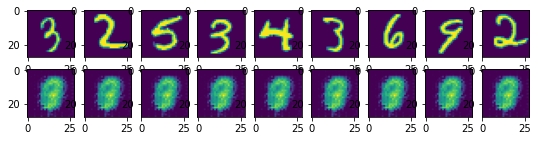

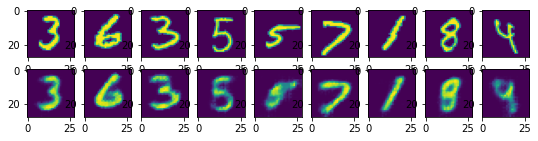

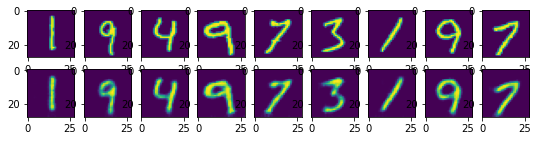

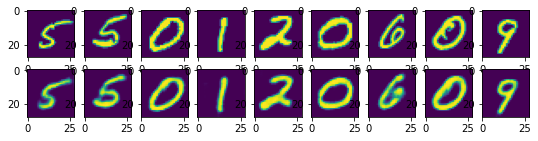

In [21]:
for k in range(0, max_epochs, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

At first, the reconstructed images look nothing like the originals. Rather, the
reconstructions look more like the average of some training images.
As training progresses, our reconstructions are clearer.


## Denoising Autoencoder
We can add noise to our data and see if we can train an autoencoder to clean out the noise added to our images.

In [22]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5)
    train_loader = torch.utils.data.DataLoader(mnist_data, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    noise = 0.5
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            
            img_noisy = img + noise * torch.randn(*img.shape)
            img_noisy = np.clip(img_noisy, 0., 1.)
            
            recon = model(img_noisy)
            #img = img.view(-1, 28 * 28)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img_noisy, recon),)
    return outputs

In [23]:
import numpy as np

# train denoising autoencoder
model = Autoencoder()
max_epochs = 20
outputs = train(model, num_epochs=max_epochs)

Epoch:1, Loss:0.0679
Epoch:2, Loss:0.0610
Epoch:3, Loss:0.0696
Epoch:4, Loss:0.0690
Epoch:5, Loss:0.0666
Epoch:6, Loss:0.0618
Epoch:7, Loss:0.0512
Epoch:8, Loss:0.0378
Epoch:9, Loss:0.0298
Epoch:10, Loss:0.0292
Epoch:11, Loss:0.0244
Epoch:12, Loss:0.0238
Epoch:13, Loss:0.0219
Epoch:14, Loss:0.0195
Epoch:15, Loss:0.0174
Epoch:16, Loss:0.0197
Epoch:17, Loss:0.0172
Epoch:18, Loss:0.0180
Epoch:19, Loss:0.0166
Epoch:20, Loss:0.0173


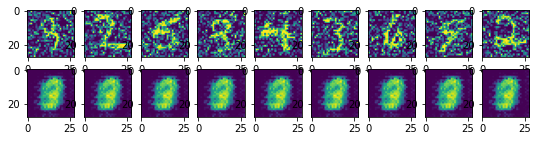

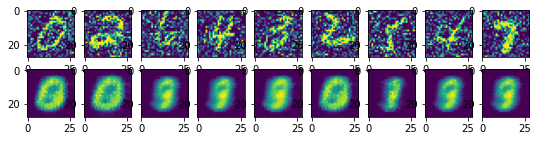

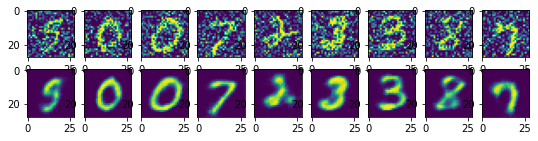

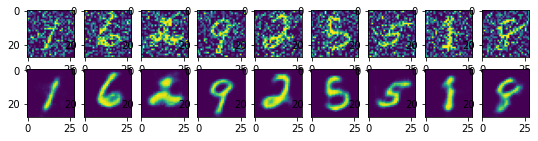

In [24]:
# reconstructed images at various parts of training
for k in range(0, max_epochs, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

### Testing on new images

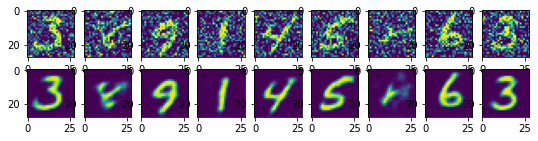

In [26]:
batch_size = 64

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)[4096:4160]

test_loader = torch.utils.data.DataLoader(mnist_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# obtain one batch of test images
dataiter = iter(test_loader)
img, labels = dataiter.next()

# add noise to the test images
noise = 0.5
img_noisy = img + noise * torch.randn(*img.shape)
img_noisy = np.clip(img_noisy, 0., 1.)

# get sample outputs
recon = model(img_noisy)
# prep images for display
img_noisy = img_noisy.numpy()
recon = recon.detach().numpy()

# reconstructed images at various parts of training
for k in range(1):
    plt.figure(figsize=(9, 2))

    for i, item in enumerate(img_noisy):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

Autoencoders are well suited for extracting compressed representations of images and can correct things that don't match the expectation. This approach can be extended to other applications such as handling object occlusion, or filling in missing segments of an image.

## Structure in the Embeddings

Since we are drastically reducing the dimensionality of the image, there has to be
some kind of structure in the embedding space. That is, the network should be able
to "save" space by mapping similar images to similar embeddings.

We will demonstrate the structure of the embedding space by having
some fun with our autoencoders. Let's begin with two images in our training set.
For now, we'll choose images of the same digit.

First load pre-denoising autoencoder architecture and training although you could also do this with the denosing autoencoder.

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)[:4096]


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    train_loader = torch.utils.data.DataLoader(mnist_data, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

In [28]:
model = Autoencoder()
max_epochs = 20
outputs = train(model, num_epochs=max_epochs)

Epoch:1, Loss:0.0670
Epoch:2, Loss:0.0668
Epoch:3, Loss:0.0492
Epoch:4, Loss:0.0329
Epoch:5, Loss:0.0249
Epoch:6, Loss:0.0189
Epoch:7, Loss:0.0162
Epoch:8, Loss:0.0161
Epoch:9, Loss:0.0150
Epoch:10, Loss:0.0118
Epoch:11, Loss:0.0094
Epoch:12, Loss:0.0098
Epoch:13, Loss:0.0110
Epoch:14, Loss:0.0087
Epoch:15, Loss:0.0078
Epoch:16, Loss:0.0085
Epoch:17, Loss:0.0076
Epoch:18, Loss:0.0071
Epoch:19, Loss:0.0064
Epoch:20, Loss:0.0066


Output two sample images

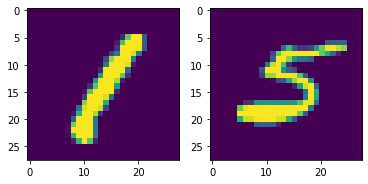

In [29]:
imgs = outputs[max_epochs-1][1].detach().numpy()
plt.subplot(1, 2, 1)
plt.imshow(imgs[0][0])
plt.subplot(1, 2, 2)
plt.imshow(imgs[8][0])

We will then compute the **low-dimensional embeddings** of both images,
by applying the **encoder**:

In [30]:
x1 = outputs[max_epochs-1][1][0,:,:,:] # first image
x2 = outputs[max_epochs-1][1][8,:,:,:] # second image
x = torch.stack([x1,x2])     # stack them together so we only call `encoder` once
embedding = model.encoder(x)
e1 = embedding[0] # embedding of first image
e2 = embedding[1] # embedding of second image

Now we will do something interesting. Not only are we going to run the
decoder on those two embeddings `e1` and `e2`, we are also going to **interpolate**
between the two embeddings and decode those as well!

In [31]:
embedding_values = []
for i in range(0, 10):
    e = e1 * (i/10) + e2 * (10-i)/10
    embedding_values.append(e)
embedding_values = torch.stack(embedding_values)

recons = model.decoder(embedding_values)

Let's plot the reconstructions of each interpolated values.
The original images are shown below too:

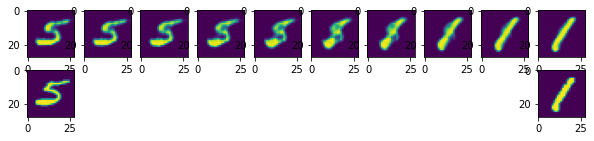

In [32]:
plt.figure(figsize=(10, 2))
for i, recon in enumerate(recons.detach().numpy()):
    plt.subplot(2,10,i+1)
    plt.imshow(recon[0])
plt.subplot(2,10,11)
plt.imshow(imgs[8][0])
plt.subplot(2,10,20)
plt.imshow(imgs[0][0])

Notice that there is a smooth transition between the two images!
The middle images are likely new, in that there are no training images
that are exactly like any of the generated images.

As promised, we can do the same thing with two images containing
different digits. There should be a smooth transition between
the two digits.

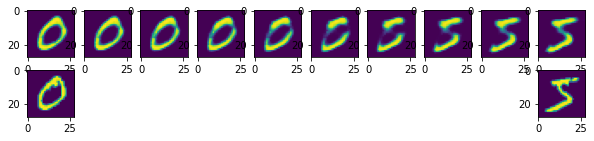

In [35]:
def interpolate(index1, index2):
    x1 = mnist_data[index1][0]
    x2 = mnist_data[index2][0]
    x = torch.stack([x1,x2])
    embedding = model.encoder(x)
    e1 = embedding[0] # embedding of first image
    e2 = embedding[1] # embedding of second image

    embedding_values = []
    for i in range(0, 10):
        e = e1 * (i/10) + e2 * (10-i)/10
        embedding_values.append(e)
    embedding_values = torch.stack(embedding_values)

    recons = model.decoder(embedding_values)

    plt.figure(figsize=(10, 2))
    for i, recon in enumerate(recons.detach().numpy()):
        plt.subplot(2,10,i+1)
        plt.imshow(recon[0])
    plt.subplot(2,10,11)
    plt.imshow(x2[0])
    plt.subplot(2,10,20)
    plt.imshow(x1[0])

interpolate(0, 1)

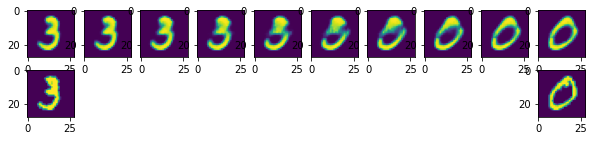

In [34]:
interpolate(1, 10)

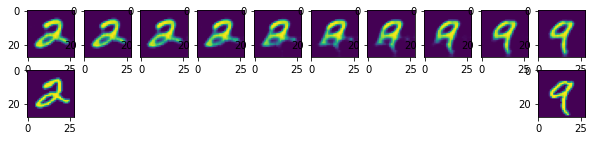

In [36]:
interpolate(4, 5)

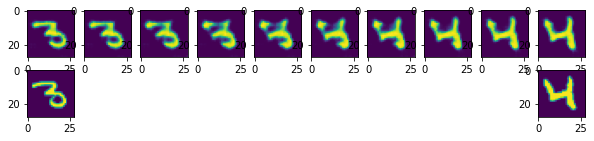

In [37]:
interpolate(20, 30)

In [38]:
def interpolate_pixel(index1, index2):
    x1 = mnist_data[index1][0]
    x2 = mnist_data[index2][0]

    interpolated_values = []
    for i in range(0, 10):
        e = x1 * (i/10) + x2 * (10-i)/10
        interpolated_values.append(e)
        
    plt.figure(figsize=(10, 2))
    for i, recon in enumerate(interpolated_values):
        plt.subplot(2,10,i+1)
        plt.imshow(recon[0])
    plt.subplot(2,10,11)
    plt.imshow(x2[0])
    plt.subplot(2,10,20)
    plt.imshow(x1[0])

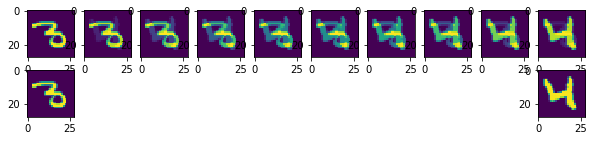

In [ ]:
interpolate_pixel(20, 30)

What happens if we randomly initialize in the embedding space?

In [39]:
d = model.decoder(torch.randn(1, 64, 1, 1)).detach().numpy()

In [40]:
d.shape

(1, 1, 28, 28)

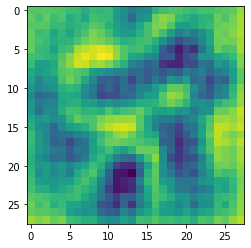

In [41]:
plt.imshow(d[0][0])

The variational autoencoder will allow us to randomly initialize in the embedding space to generate new MNIST-like samples. Provided below is sample code showing how to do that.

## Variational Autoencoder

![alt text](http://kvfrans.com/content/images/2016/08/vae.jpg)

To allow us to sample from the embedding space and generate new images, we add a constraint on the encoding network that forces it to generate latent vectors that roughly follow a unit Gaussian distribution. This constraint is what separates a variational autoencoder from the ones we've seen up until now.

Now generating new images requires that we sample a latent vector from the unit Gaussian and pass it into the decoder.

As shown in the figure, we will have encoding and decoding networks similar to what we used before, whether with fully-connected or convolutional layers. Then we add two additional linear layers to hold the mean and standard deviation vectors of the embedding space. We will need some way to generate a sampled latent space which will act as input to the decoding network.

We will also need to update our loss function to use Kullback-Leibler divergence to constrain the embedding space to follow a unit Gaussian distribution. You will not be required to know the math behind this.

A demonstration of the variational autoencoder is provided below.

In [42]:
#Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# train data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
                   batch_size=64, shuffle=True)

# test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=64, shuffle=True)


In [43]:
# dimensions of latent space
zdim = 25

# Variational Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # encoder
        self.fc1 = nn.Linear(28 * 28, 350)
        self.relu = nn.ReLU()
        self.fc2m = nn.Linear(350, zdim)  # mu layer
        self.fc2s = nn.Linear(350, zdim)  # sd layer

        # decoder
        self.fc3 = nn.Linear(zdim, 350)
        self.fc4 = nn.Linear(350, 28 * 28)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc2m(h1), self.fc2s(h1)

    # reparameterize
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [44]:
# loss function for VAE are unique and use Kullback-Leibler
# divergence measure to force distribution to match unit Gaussian
def loss_function(recon_x, x, mu, logvar):
    bce = F.binary_cross_entropy(recon_x, x.view(-1, 28 * 28))
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kld /= batch_size * 28 * 28
    return bce + kld

In [45]:
def train(model, num_epochs = 1, batch_size = 64, learning_rate = 1e-3):
    model.train() #train mode so that we do reparameterization
    torch.manual_seed(42)
    
    train_loader = torch.utils.data.DataLoader(datasets.MNIST('data', 
               train=True, download=True, transform=transforms.ToTensor()),
               batch_size = batch_size, shuffle = True)
    
    optimizer = optim.Adam(model.parameters(), learning_rate)
    
    for epoch in range(num_epochs):
      for data in train_loader:  # load batch
          img, _ = data
          
          recon, mu, logvar = model(img)
          loss = loss_function(recon, img, mu, logvar) # calculate loss
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
      
      print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))

In [46]:
batch_size = 64

model = Autoencoder()
train(model, num_epochs = 30, batch_size = batch_size)

Epoch:1, Loss:0.1586
Epoch:2, Loss:0.1418
Epoch:3, Loss:0.1228
Epoch:4, Loss:0.1224
Epoch:5, Loss:0.1187
Epoch:6, Loss:0.1104
Epoch:7, Loss:0.1276
Epoch:8, Loss:0.1221
Epoch:9, Loss:0.1163
Epoch:10, Loss:0.1218
Epoch:11, Loss:0.1257
Epoch:12, Loss:0.1127
Epoch:13, Loss:0.1087
Epoch:14, Loss:0.1192
Epoch:15, Loss:0.1122
Epoch:16, Loss:0.1083
Epoch:17, Loss:0.1105
Epoch:18, Loss:0.1139
Epoch:19, Loss:0.1097
Epoch:20, Loss:0.1169
Epoch:21, Loss:0.1041
Epoch:22, Loss:0.1148
Epoch:23, Loss:0.1118
Epoch:24, Loss:0.1095
Epoch:25, Loss:0.1121
Epoch:26, Loss:0.1156
Epoch:27, Loss:0.1279
Epoch:28, Loss:0.1223
Epoch:29, Loss:0.1170
Epoch:30, Loss:0.1148


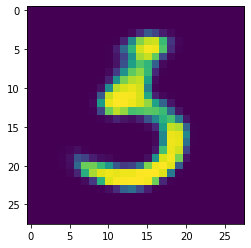

In [47]:
# generate random samples in latent space
model.eval()
sample = torch.randn(64, zdim)
sample = model.decode(sample)

import matplotlib.pyplot as plt
imgs = sample.data.view(64, 28, 28).numpy()
plt.imshow(imgs[4])

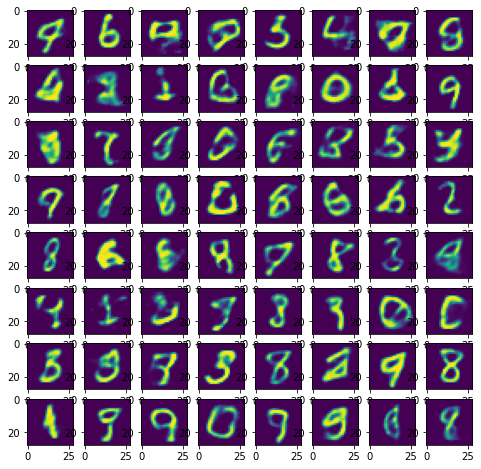

In [48]:
# display images
for k in range(1):
    plt.figure(figsize=(8, 8))

    for i, item in enumerate(imgs):
        plt.subplot(8, 8, i+1)
        plt.imshow(item)

In summary we have learned about several different autoencoders. The different architectures we explored with stacked, convolutional, denoising, and variational autoencoders can be combined to take advantage of their strengths and weaknesses to develop an architecture best suited for your problem.

In this tutorial we didn't go over **semi-supervised learning** which is another very practical application of autoencoders. By learning embeddings from unlabeled data, autoencoders can improve model performance in situations where labeled data may be scarce.